In [1]:
import math, random

import torch
import torch.nn as nn
from torch.nn import init, functional
from torch.utils.data import DataLoader, Dataset, random_split

import torchaudio
from torchaudio import transforms

from scipy.signal import filtfilt
from scipy import stats
import scipy

import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinarySpecificity
from sklearn import metrics

import pandas as pd
import numpy as np
from IPython.display import Audio
from matplotlib import pyplot as plt
from os import walk

from packages.metrics_saver import update_metrics, get_metrics

In [2]:
#To allow plotting pytorch tensors
torch.Tensor.ndim = property(lambda self: len(self.shape))
#use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [3]:
SEED = 0
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Audio Properties

In [4]:
MAX_AUDIO_LENGTH = 10000
SAMPLING_RATE = 2000
N_CHANNELS = 1
SHIFT_PCT = 0.2
FREQ_SHIFT_PCT = 1

LOW_FREQ = 15
HIGH_FREQ = 400
ORDER = 3

SPEC_HOP_LENGTH=64
SPEC_N_FFT=256   # standard number
SPEC_N_MELS=128  

MFCC_HOP_LENGTH=64
MFCC_N_FFT=256   # standard number
MFCC_N_MELS=64  
N_MFCC=14   # standard number

In [5]:
BATCH_SIZE = 64

# AudioUtils

In [6]:
class AudioUtil():
    @staticmethod
    def open(audio_file):

        #Open an audio file
        # print(f"Opening file : {audio_file}")
        sig, sr = torchaudio.load(audio_file)
        sig.to(device)
        return (sig, sr)
    
    @staticmethod
    def print(aud, channel, title='Audio Plot'):

        #Plot the audio signal wave

        sig, sr = aud
        duration = sig.shape[1]
        time = torch.linspace(0, duration/sr, duration)

        print(sig.shape)
        print('Plotting...')

        plt.figure(figsize=(10, 5))
        plt.plot(time, sig.cpu()[channel - 1])
        plt.title(title)
        plt.ylabel(' signal wave')
        plt.xlabel('time (s)')
        plt.show()

    @staticmethod
    def display_spectrogram(spec, label='Audio mel spectrogram'):
        
        #Display the audio mel spectrogram

        print(spec.shape)
        print('Plotting...')
        
        plt.figure(figsize=(15,5))
        plt.imshow(spec, origin='lower', aspect='auto', cmap='RdBu_r')
        plt.title(label)
        plt.ylabel('Frequency (mels)')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()
    
    @staticmethod
    def display_MFCC(mfcc, label='Audio MFCCs', type='image'):
        
        #Display the audio MFCCs

        print(mfcc.shape)
        print('Plotting...')

        if(type == 'graph'):
            plt.figure(figsize=(15,5))
            # ([1, 13, 501])
            for i,d in enumerate(mfcc[0]):
                plt.plot(d, label='mfcc ' + str(i))
            plt.title(label)
            plt.ylabel('Amplitude')
            plt.xlabel('Time (ms)')
            plt.legend()
            plt.show()
            return
        
        plt.figure(figsize=(15,5))
        plt.imshow(mfcc[0], aspect='auto')
        plt.title(label)
        plt.ylabel('Index')
        plt.xlabel('Time (ms)')
        plt.colorbar(format='%+2.0f dB')

        plt.show()

    @staticmethod
    def rechannel(aud, new_channel):

        #Convert the audio from mono to stereo or vice versa

        sig, sr = aud

        if(sig.shape[0] == new_channel):
            return aud
        
        # print('Rechanneling to ' + str(new_channel))
        if(new_channel == 1):
            resig = sig[:1, :]
        else:
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))

    @staticmethod
    def resample(aud, newsr):

        #Resample the audio to the newsr frequency

        sig, sr = aud
        
        if(sr == newsr):
            return((sig, sr))
        
        # print('Resampling to ' + str(newsr))

        num_channels = sig.shape[0]
        resig_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
        resig = resig_fn(sig[:1, :].to(device))
        if(num_channels > 1):
            retwo_fn = torchaudio.transforms.Resample(sr, newsr).to(device)
            retwo = retwo_fn(sig[1:, :].to(device))
            resig = torch.cat([resig, retwo])

        return((resig, newsr))

    @staticmethod
    def butterworth_filter(aud, low_cutoff_freq=15, high_cutoff_freq=900, order=3):
        sig, sr = aud

        nyq = 0.5 * sr
        low = low_cutoff_freq / nyq
        high = high_cutoff_freq / nyq
        
        b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
        filtered_sig = scipy.signal.filtfilt(b, a, sig.cpu(), axis=1)
        filtered_sig = torch.Tensor(filtered_sig.copy()).to(device)
        
        return ((filtered_sig, sr))

    @staticmethod
    def pad_trunc(aud, max_len):
        #add padding, or truncate the signal to fit the max length
        sig, sr = aud
        num_rows, sig_len = sig.shape

        if(sig_len > max_len):
            #Truncate the signal
            # print('Truncating signal to ' + str(max_ms) + ' ms')
            sig = sig[:, :max_len]
        elif(sig_len < max_len):
            #Add padding
            # print('Padding signal to ' + str(max_ms) + ' ms')
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_rows, pad_begin_len)).to(device)
            pad_end = torch.zeros((num_rows, pad_end_len)).to(device)

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return ((sig, sr))

    @staticmethod
    def time_shift(aud, shift_limit):
        sig, sr = aud
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)

    @staticmethod
    def pitch_shift(aud, shift_limit):
        sig, sr = aud
        shift_amt = random.random() * shift_limit
        return (sig * shift_amt, sr)

    @staticmethod
    def get_mel_spectrogram(aud, hop_length=512, n_fft=1024, n_mels=64):
        sig, sr = aud
        top_db = 80

        mel_transformation = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        db_transformation = torchaudio.transforms.AmplitudeToDB(top_db=top_db)
        mel_transformation.to(device)
        db_transformation.to(device)
        spec = mel_transformation(sig.to(device))
        spec = db_transformation(spec.to(device))
        return spec
    
    @staticmethod
    def get_spectrogram(aud, hop_length=512, n_fft=1024, n_mels=64, mel=False, db=False):
        sig, sr = aud

        if mel:
            mel_transformation = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
            mel_transformation.to(device)
            spec = mel_transformation(sig.to(device))
        else:
            transformation = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)
            transformation.to(device)
            spec = transformation(sig.to(device))

        if db:
            top_db = 80
            db_transformation = torchaudio.transforms.AmplitudeToDB(top_db=top_db)
            db_transformation.to(device)
            spec = db_transformation(spec.to(device))
        
        return spec

    @staticmethod
    def spectro_augment(spec, max_mask_pct = 0.1, n_freq_masks = 1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_max_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_max_param).to(device)(aug_spec, mask_value)
        time_mask_params = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_params).to(device)(aug_spec, mask_value)

        return aug_spec

    @staticmethod
    def get_MFCC(aud, hop_length=512, n_fft=1024, n_mels=64, n_mfcc = 64):
        sig, sr = aud
        mfcc_fn = transforms.MFCC(  sample_rate=sr,
                                    n_mfcc=n_mfcc,
                                    melkwargs={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length})
        mfcc_fn.to(device)
        return mfcc_fn(sig.to(device))
    
    @staticmethod
    def get_DeltaMFCC(mfcc):
        delta_fn = torchaudio.transforms.ComputeDeltas().to(device)
        delta_mfcc = delta_fn(mfcc)
        delta2_mfcc = delta_fn(delta_mfcc)

        return (delta_mfcc, delta2_mfcc)
    
    @staticmethod
    def getWindows(aud, window_len=5000, overlap=0.1, test=False, mfcc=False, delta=False):
        sig, sr = aud
        sig_len = len(sig[0])
        result = []
        if(sig_len <= window_len):
            w_aud = AudioUtil.pad_trunc(aud, window_len)
            w_aud = AudioUtil.pitch_shift(w_aud, SHIFT_PCT)
            if mfcc:
                w_spec = AudioUtil.get_MFCC(w_aud, MFCC_HOP_LENGTH, MFCC_N_FFT, MFCC_N_MELS, n_mfcc=N_MFCC)
                if delta:
                    delta_1, delta_2 = AudioUtil.get_DeltaMFCC(w_spec)
                    w_spec = torch.cat([w_spec, delta_1, delta_2], dim=0)
            else:
                w_spec = AudioUtil.get_mel_spectrogram(w_aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS)
                if delta:
                    delta_1, delta_2 = AudioUtil.get_DeltaMFCC(w_spec)
                    w_spec = torch.cat([w_spec, delta_1, delta_2], dim=0)
                if not test:
                    w_spec = AudioUtil.spectro_augment(w_spec, n_freq_masks=1, n_time_masks=2)
            result.append(w_spec)
        else:
            start = 0
            end = window_len
            while end <= sig_len:
                w = sig[0][start:end]
                w_aud = (w.unsqueeze(dim=0), sr)
                w_aud = AudioUtil.pitch_shift(w_aud, SHIFT_PCT)
                if mfcc:
                    w_spec = AudioUtil.get_MFCC(w_aud, MFCC_HOP_LENGTH, MFCC_N_FFT, MFCC_N_MELS, n_mfcc=N_MFCC)
                    if delta:
                        delta_1, delta_2 = AudioUtil.get_DeltaMFCC(w_spec)
                        w_spec = torch.cat([w_spec, delta_1, delta_2], dim=0)
                else:
                    w_spec = AudioUtil.get_mel_spectrogram(w_aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS)
                    if delta:
                        delta_1, delta_2 = AudioUtil.get_DeltaMFCC(w_spec)
                        w_spec = torch.cat([w_spec, delta_1, delta_2], dim=0)
                    if not test:
                        w_spec = AudioUtil.spectro_augment(w_spec, n_freq_masks=1, n_time_masks=2)
                result.append(w_spec)

                start = int(end - overlap * window_len)
                end = int(start + window_len)
        return result

    @staticmethod
    def preprocess_audio_windowed(audio_dir, test=False, mfcc=False, delta=False):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
        result = AudioUtil.getWindows(aud, MAX_AUDIO_LENGTH, overlap=0.1, test=test, mfcc=mfcc, delta=delta)
        return result

    @staticmethod
    def preprocess_audio_only(audio_dir):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, FREQ_SHIFT_PCT)
        sig, sr = aud
        return sig
    @staticmethod
    def preprocess_audio(audio_dir):
        aud = AudioUtil.open(audio_dir)
        aud = AudioUtil.rechannel(aud, N_CHANNELS)
        aud = AudioUtil.resample(aud, SAMPLING_RATE)
        aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
        aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
        sig, sr = aud
        print(sig.shape)
        aud = AudioUtil.time_shift(aud, SHIFT_PCT)
        aud = AudioUtil.pitch_shift(aud, SHIFT_PCT)
        
        spec = AudioUtil.get_mel_spectrogram(aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS)
        aug_spec = AudioUtil.spectro_augment(spec, n_freq_masks=2, n_time_masks=2)
        mfcc = AudioUtil.get_MFCC(aud, hop_length=MFCC_HOP_LENGTH, n_fft=MFCC_N_FFT, n_mels=MFCC_N_MELS, n_mfcc=N_MFCC)
        mfcc_1, mfcc_2 = AudioUtil.get_DeltaMFCC(mfcc)
        return (aud, spec, aug_spec, mfcc, mfcc_1, mfcc_2)

# Import Dataset

In [7]:
from packages.physionet_importer import getTrainingSet, getValidationSet
from packages.pascal_importer import getPreprocessedData
physionet_df = getTrainingSet()
pascal_df = getPreprocessedData()
df = physionet_df

0    2575
1     665
Name: classID, dtype: int64
Dataset/PASCAL/normal [462]
Dataset/PASCAL/abnormal [328]


# Visualize

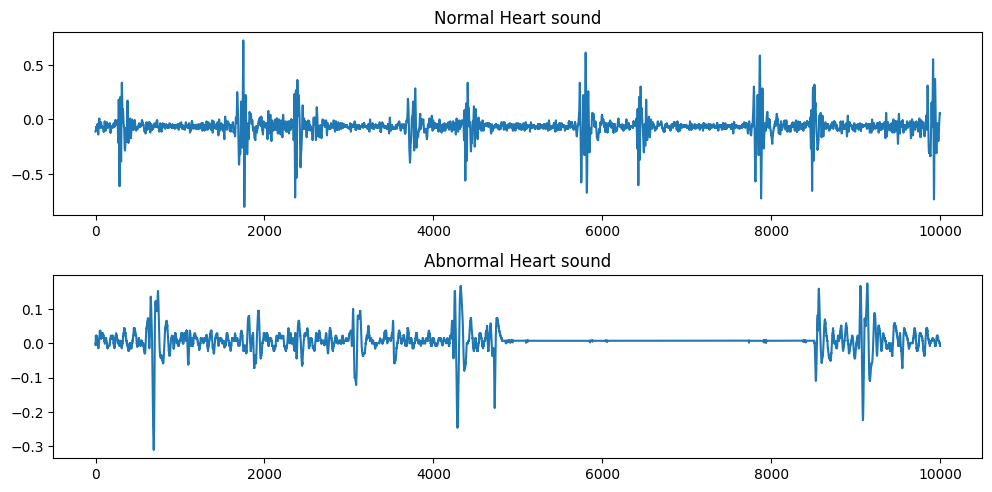

In [8]:
normal_df = df[df['classID'] == 0]
normal_audio_dir = normal_df.iloc[random.randint(0, len(normal_df))].relative_path
normal_sig, sr = AudioUtil.open(normal_audio_dir)
normal_sig = normal_sig.to(device)
normal_aud = (normal_sig, sr)
normal_aud = AudioUtil.pad_trunc(normal_aud, MAX_AUDIO_LENGTH)
normal_aud = AudioUtil.rechannel(normal_aud, N_CHANNELS)
normal_aud = AudioUtil.resample(normal_aud, SAMPLING_RATE)

fig = plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
b_sig, b_sr = normal_aud
plt.plot(b_sig[0].cpu())
plt.title('Normal Heart sound')


abnormal_df = df[df['classID'] == 1]
abnormal_audio_dir = abnormal_df.iloc[random.randint(0, len(abnormal_df))].relative_path
abnormal_sig, sr = AudioUtil.open(abnormal_audio_dir)
abnormal_sig = abnormal_sig.to(device)
abnormal_aud = (abnormal_sig, sr)
abnormal_aud = AudioUtil.pad_trunc(abnormal_aud, MAX_AUDIO_LENGTH)
abnormal_aud = AudioUtil.rechannel(abnormal_aud, N_CHANNELS)
abnormal_aud = AudioUtil.resample(abnormal_aud, SAMPLING_RATE)

plt.subplot(2, 1, 2)
a_sig, a_sr = abnormal_aud
plt.plot(a_sig[0].cpu())
plt.title('Abnormal Heart sound')

fig.tight_layout(pad=1)
plt.show()

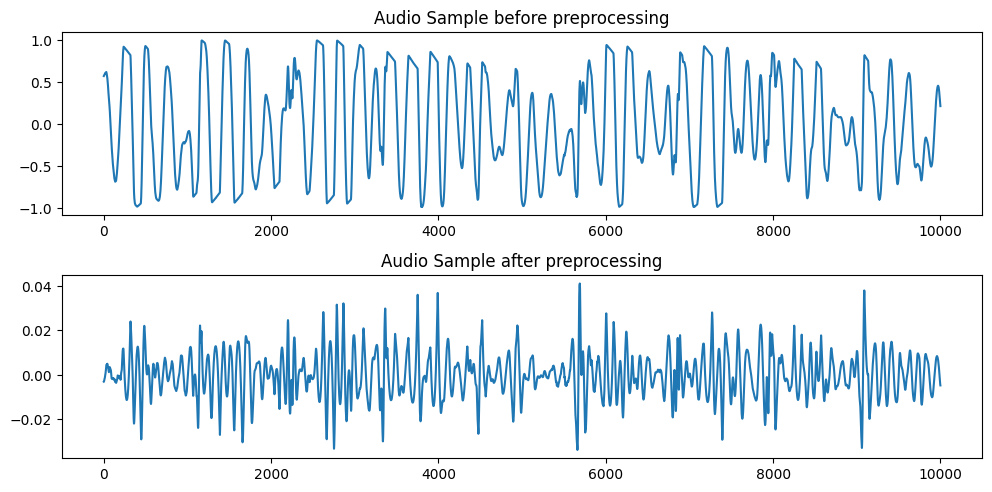

In [9]:
normal_df = df[df['classID'] == 0]
audio_dir = normal_df.iloc[random.randint(0, len(normal_df))].relative_path
sig, sr = AudioUtil.open(audio_dir)
sig = sig.to(device)
aud = (sig, sr)
before = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
aud = AudioUtil.rechannel(before, N_CHANNELS)
aud = AudioUtil.resample(aud, SAMPLING_RATE)
aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
after = AudioUtil.pitch_shift(aud, SHIFT_PCT)

fig = plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
b_sig, b_sr = before
plt.plot(b_sig[0].cpu())
plt.title('Audio Sample before preprocessing')

plt.subplot(2, 1, 2)
a_sig, a_sr = after
plt.plot(a_sig[0].cpu())
plt.title('Audio Sample after preprocessing')

fig.tight_layout(pad=1)
plt.show()

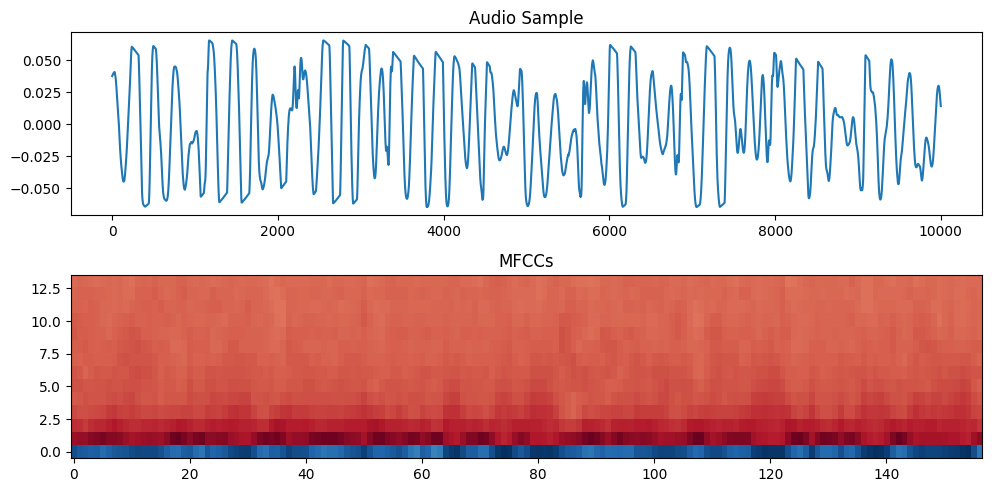

In [10]:
normal_df = df[df['classID'] == 0]
audio_dir = normal_df.iloc[4].relative_path
sig, sr = AudioUtil.open(audio_dir)
sig = sig.to(device)
aud = (sig, sr)
aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
aud = AudioUtil.rechannel(aud, N_CHANNELS)
aud = AudioUtil.resample(aud, SAMPLING_RATE)
aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
aud = AudioUtil.pitch_shift(before, SHIFT_PCT)
mel_spec = AudioUtil.get_spectrogram(aud, hop_length=SPEC_HOP_LENGTH, n_fft=SPEC_N_FFT, n_mels=SPEC_N_MELS, mel=True,db=True)
w_spec = AudioUtil.get_MFCC(aud, MFCC_HOP_LENGTH, MFCC_N_FFT, MFCC_N_MELS, n_mfcc=N_MFCC)

fig = plt.figure(figsize=(10,5))
plt.subplot(2, 1, 1)
sig1, sr1 = aud
plt.plot(sig1[0].cpu())
plt.title('Audio Sample')

plt.subplot(2, 1, 2)
plt.imshow(w_spec[0].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.title('MFCCs')

fig.tight_layout(pad=1)
plt.show()

In [ ]:
normal_df = df[df['classID'] == 0]
audio_dir = normal_df.iloc[random.randint(0, len(normal_df))].relative_path
sig, sr = AudioUtil.open(audio_dir)
sig = sig.to(device)
aud = (sig, sr)
aud = AudioUtil.pad_trunc(aud, MAX_AUDIO_LENGTH)
aud = AudioUtil.rechannel(before, N_CHANNELS)
aud = AudioUtil.resample(aud, SAMPLING_RATE)
aud = AudioUtil.butterworth_filter(aud, LOW_FREQ, HIGH_FREQ, ORDER)
aud = AudioUtil.pitch_shift(aud, SHIFT_PCT)

fig = plt.figure(figsize=(10,5))
b_sig, b_sr = aud
plt.plot(b_sig[0].cpu())
plt.title('Audio Sample before segmentation')

plt.show()

In [11]:
import IPython
# IPython.display.Audio('./Dataset/PhysioNet/validation/a0009.wav')
Audio(b_sig.cpu(), rate=a_sr)

In [12]:
normal_df = df[df['classID'] == 0]
print('Number of Normal Samples: ' + str(len(normal_df)))
normal_sample = normal_df.iloc[random.randint(0, len(normal_df))]
normal_spec = AudioUtil.preprocess_audio_windowed(normal_sample.relative_path, mfcc=True, delta=True, test=True)[0]

abnormal_df = df[df['classID'] == 1]
print('Number of Abnormal Samples: ' + str(len(abnormal_df)))
abnormal_sample = normal_df.iloc[random.randint(0, len(abnormal_df))]
abnormal_spec = AudioUtil.preprocess_audio_windowed(abnormal_sample.relative_path, mfcc=True, delta=True, test=True)[0]

Number of Normal Samples: 2575
Number of Abnormal Samples: 665


In [29]:
abnormal_sample

file_name                                              a0086.wav
classID                                                        0
relative_path    Dataset/PhysioNet/training/training-a/a0086.wav
Name: 85, dtype: object

In [13]:
normal_spec.shape

torch.Size([3, 14, 157])

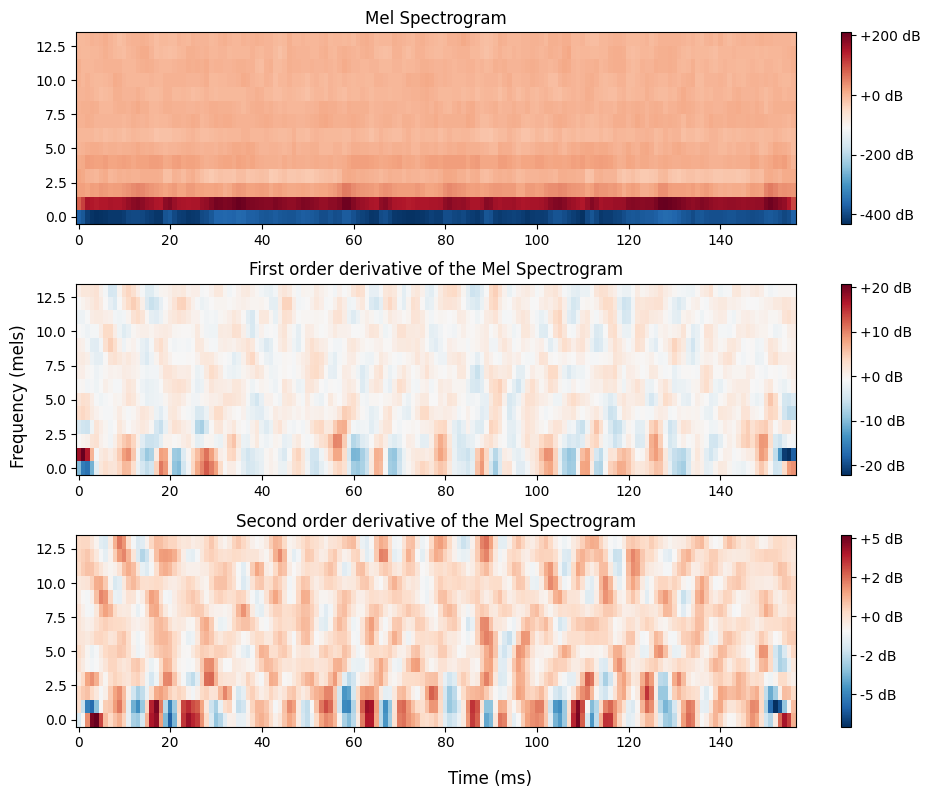

In [14]:
fig = plt.figure(figsize=(10,8))
fig.supylabel('Frequency (mels)')
fig.supxlabel('Time (ms)')
plt.subplot(3,1,1)
plt.imshow(normal_spec[0].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')

plt.subplot(3,1,2)
plt.imshow(normal_spec[1].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('First order derivative of the Mel Spectrogram')

plt.subplot(3,1,3)
plt.imshow(normal_spec[2].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Second order derivative of the Mel Spectrogram')

fig.tight_layout(pad=1)

plt.show()

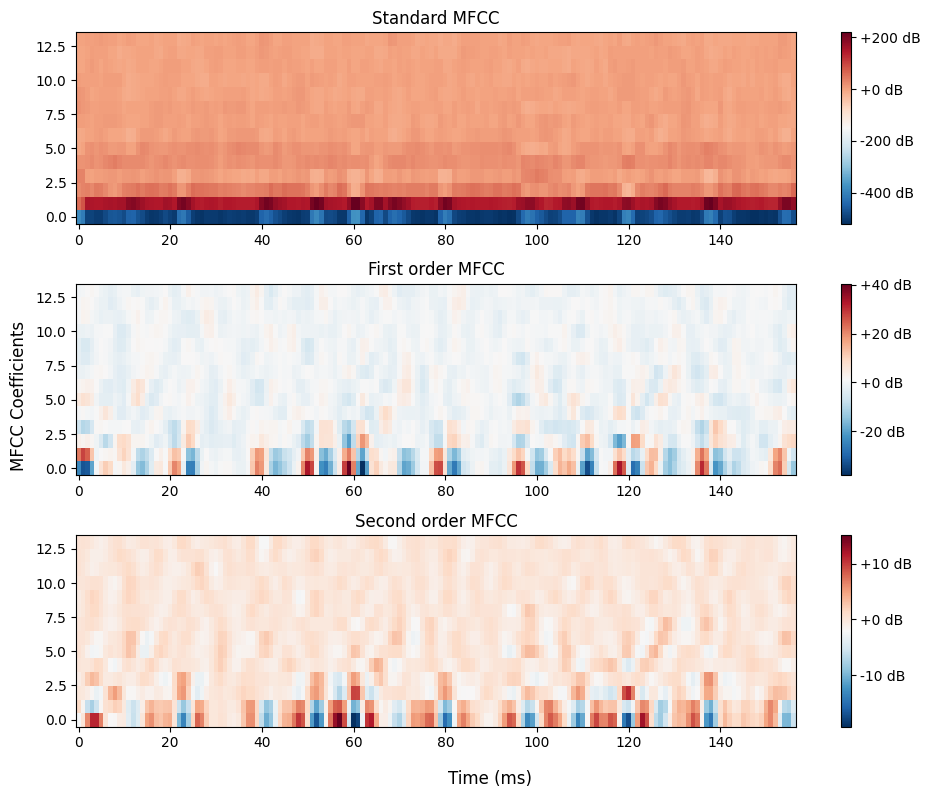

In [15]:
fig = plt.figure(figsize=(10,8))
fig.supylabel('MFCC Coefficients')
fig.supxlabel('Time (ms)')
plt.subplot(3,1,1)
plt.imshow(abnormal_spec[0].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Standard MFCC')

plt.subplot(3,1,2)
plt.imshow(abnormal_spec[1].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('First order MFCC')

plt.subplot(3,1,3)
plt.imshow(abnormal_spec[2].cpu(), origin='lower', aspect='auto', cmap='RdBu_r')
plt.colorbar(format='%+2.0f dB')
plt.title('Second order MFCC')

fig.tight_layout(pad=1)

plt.show()

torch.Size([14, 157])
Plotting...


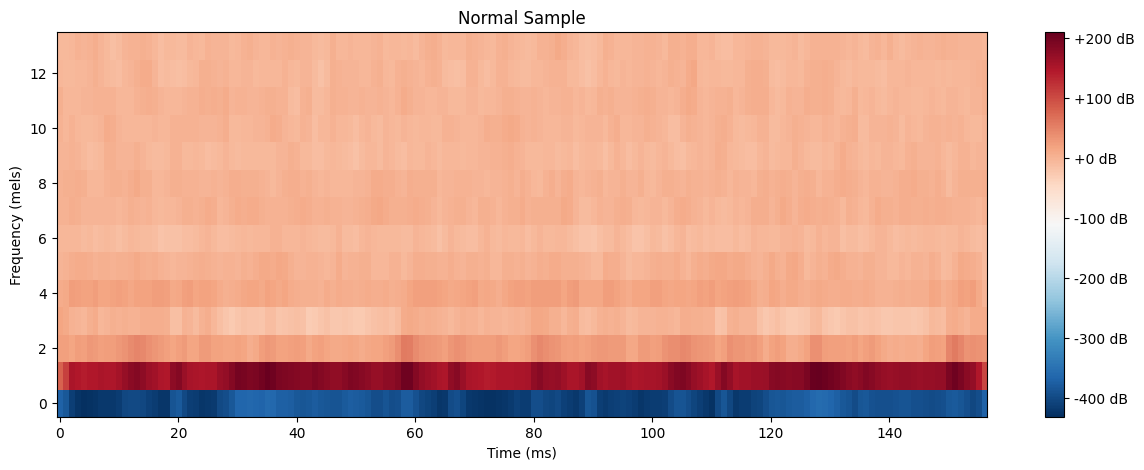

torch.Size([14, 157])
Plotting...


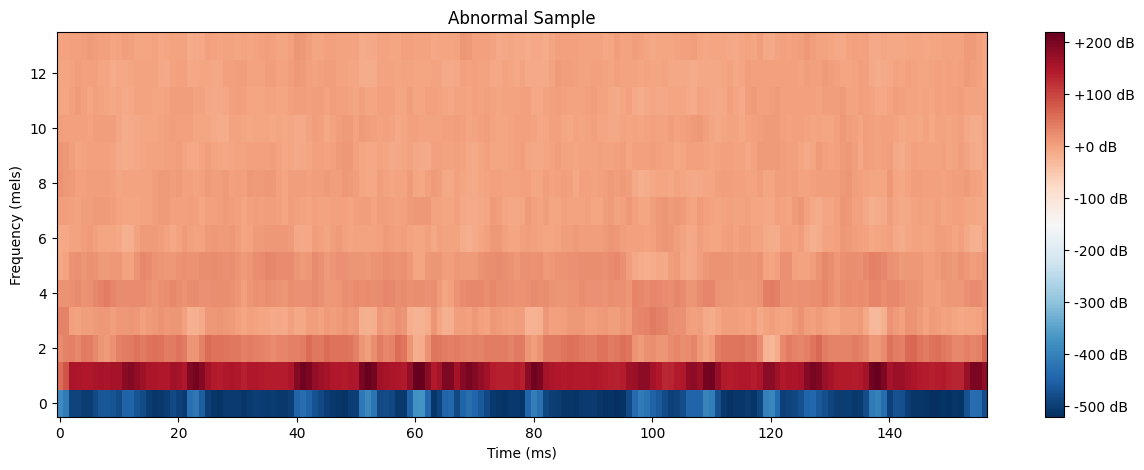

In [16]:
AudioUtil.display_spectrogram(normal_spec[0].cpu(), 'Normal Sample')
AudioUtil.display_spectrogram(abnormal_spec[0].cpu(), 'Abnormal Sample')

torch.Size([14, 157])
Plotting...


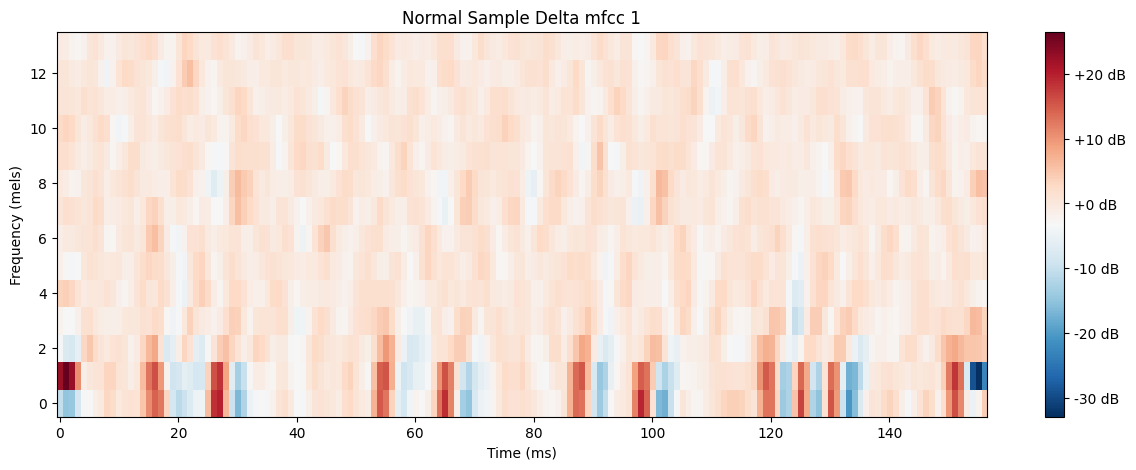

torch.Size([14, 157])
Plotting...


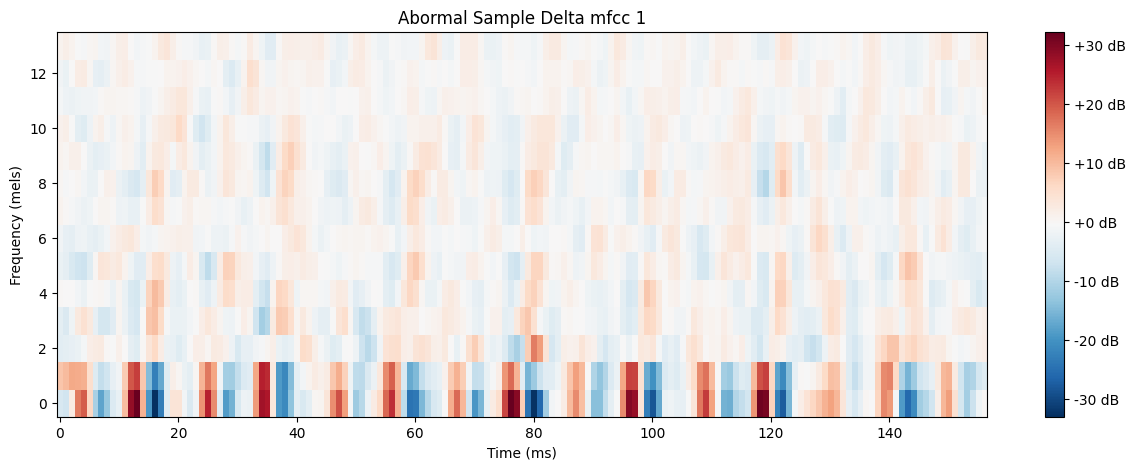

torch.Size([14, 157])
Plotting...


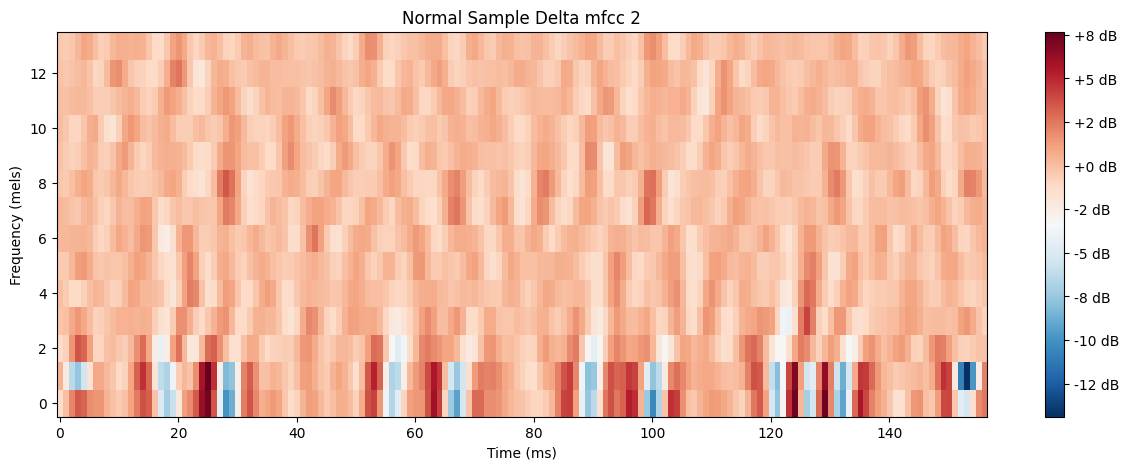

torch.Size([14, 157])
Plotting...


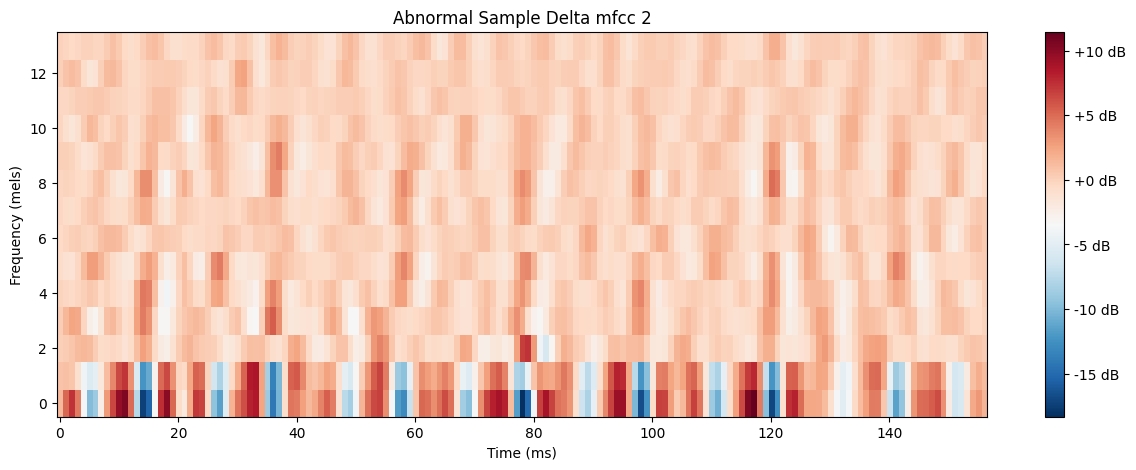

In [53]:
AudioUtil.display_spectrogram(normal_spec[1].cpu(), 'Normal Sample Delta mfcc 1')
AudioUtil.display_spectrogram(abnormal_spec[1].cpu(), 'Abormal Sample Delta mfcc 1')

AudioUtil.display_spectrogram(normal_spec[2].cpu(), 'Normal Sample Delta mfcc 2')
AudioUtil.display_spectrogram(abnormal_spec[2].cpu(), 'Abnormal Sample Delta mfcc 2')

# Custom Sound Dataset

In [54]:
class SoundDS(Dataset):
    # constructor
    def __init__(self, _df, test=False, mfcc=False, delta=False):
        super().__init__()
        self.df = _df
        self.test = test
        self.mfcc = mfcc
        self.delta = delta
    
    # get length of ds
    def __len__(self):
        return len(self.df)
    
    # get i'th item in dataset
    def __getitem__(self, idx):
        audio_file = self.df.loc[idx, 'relative_path']  # get audio file path
        class_id = self.df.loc[idx, 'classID']          # get class id
        
        result = AudioUtil.preprocess_audio_windowed(audio_file, self.test, self.mfcc, self.delta)
        
        return result, class_id

# Random Split

In [55]:
ds = SoundDS(df, mfcc=False, delta=True, test=True)

num_items = len(ds)
num_train = round(num_items * 0.75) # 75 % training
num_val = round(num_items * 0.15) # 15 % validation
num_test = num_items - num_train - num_val # 10 % test

torch.manual_seed(torch.initial_seed())
train_ds, val_ds, test_ds = random_split(ds, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(SEED))

In [56]:
d, _ = train_ds[0]
d[0].shape

torch.Size([3, 128, 157])

# Saving Dataset

In [57]:
SAVE = False
SAVE_FULL_DF = True
SAVE_PATH = 'Dataset/PASCALPeprocessedWindowedDeltaSpec'

In [58]:
if SAVE_FULL_DF:
    full_df = pd.DataFrame(columns=['relative_path', 'classID', 'original_file'])
    full_path = SAVE_PATH + '/full'
    for i, (data, classID) in enumerate(ds):
        for j, sig in enumerate(data):
            original_file = 'data_' + str(i)
            file_path = full_path + '/data_' + str(i) + '_' + str(j) + '.pth'
            torch.save(sig, file_path)
            full_df.loc[len(full_df)] = [file_path, classID, original_file]
        if(i == len(ds) - 1):
            break
    print(full_df)
    full_df.to_csv(full_path + '/REFERENCES.csv')

                                         relative_path  classID original_file
0    Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        0        data_0
1    Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        0        data_1
2    Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        0        data_1
3    Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        0        data_2
4    Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        0        data_3
..                                                 ...      ...           ...
449  Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        1      data_392
450  Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        1      data_393
451  Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        1      data_393
452  Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        1      data_394
453  Dataset/PASCALPeprocessedWindowedDeltaSpec/ful...        1      data_394

[454 rows x 3 columns]


In [59]:
if SAVE:
    train_df = pd.DataFrame(columns=['relative_path', 'classID', 'original_file'])
    train_path = SAVE_PATH + '/train'
    for i, (data, classID) in enumerate(train_ds):
        for j, sig in enumerate(data):
            original_file = 'data_' + str(i)
            file_path = train_path + '/data_' + str(i) + '_' + str(j) + '.pth'
            torch.save(sig, file_path)
            train_df.loc[len(train_df)] = [file_path, classID, original_file]
    print(train_df)
    train_df.to_csv(train_path + '/REFERENCES.csv')

In [60]:
if SAVE:
    val_df = pd.DataFrame(columns=['relative_path', 'classID', 'original_file'])
    val_path = SAVE_PATH + '/validation'
    for i, (data, classID) in enumerate(val_ds):
        for j, sig in enumerate(data):
            original_file = 'data_' + str(i)
            file_path = val_path + '/data_' + str(i) + '_' + str(j) + '.pth'
            torch.save(sig, file_path)
            val_df.loc[len(val_df)] = [file_path, classID, original_file]
    print(val_df)
    val_df.to_csv(val_path + '/REFERENCES.csv')

In [61]:
if SAVE:
    test_df = pd.DataFrame(columns=['relative_path', 'classID', 'original_file'])
    test_path = SAVE_PATH + '/test'
    for i, (data, classID) in enumerate(test_ds):
        for j, sig in enumerate(data):
            original_file = 'data_' + str(i)
            file_path = test_path + '/data_' + str(i) + '_' + str(j) + '.pth'
            torch.save(sig, file_path)
            test_df.loc[len(test_df)] = [file_path, classID, original_file]
    print(test_df)
    test_df.to_csv(test_path + '/REFERENCES.csv')

In [62]:
def plot_distribution(PATH, title='Sample Data'):
    train_df = pd.read_csv(PATH + '/train/REFERENCES.csv')
    val_df = pd.read_csv(PATH + '/validation/REFERENCES.csv')
    test_df = pd.read_csv(PATH + '/test/REFERENCES.csv')
    train_data = [len(train_df), len(train_df[train_df['classID'] == 0]), len(train_df[train_df['classID'] == 1])]
    val_data = [len(val_df), len(val_df[val_df['classID'] == 0]), len(val_df[val_df['classID'] == 1])]
    test_data = [len(test_df), len(test_df[test_df['classID'] == 0]), len(test_df[test_df['classID'] == 1])]
    data = np.array([train_data[1], train_data[2], val_data[1], val_data[2], test_data[1], test_data[2]])
    data = data.reshape(3,2)

    fig, ax = plt.subplots(figsize=(10,5))
    normal_bars = ax.bar([0, 3, 6], data[:, 0], label='Normal', width=0.9, zorder=2)
    abnormal_bars = ax.bar([1, 4, 7], data[:, 1], label='Abnormal', width=0.9, zorder=2)
    ax.set_ylabel('Number of Samples')
    ax.set_title(title)
    ax.set_xticks([0.5, 3.5, 6.5])
    ax.set_xticklabels(['Training set',  'Validation set', 'Test set'])
    ax.legend()
    ax.grid(axis='y', zorder=1, linewidth=0.4)

    def autolabel(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(normal_bars)
    autolabel(abnormal_bars)
    plt.ylim(top=data.max()*1.1)
    plt.subplots_adjust(wspace=1)
    # show the plot
    plt.show()


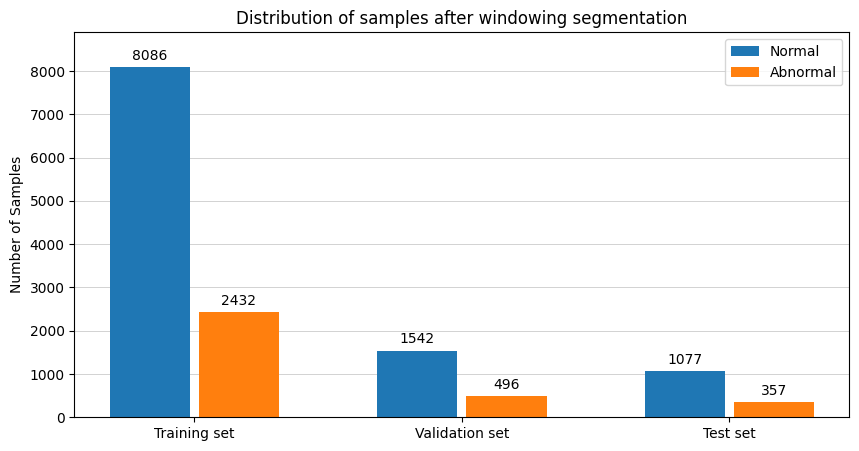

In [63]:
plot_distribution('Dataset/PhysioNetPreprocessedWindowedDeltaMFCC', 'Distribution of samples after windowing segmentation')

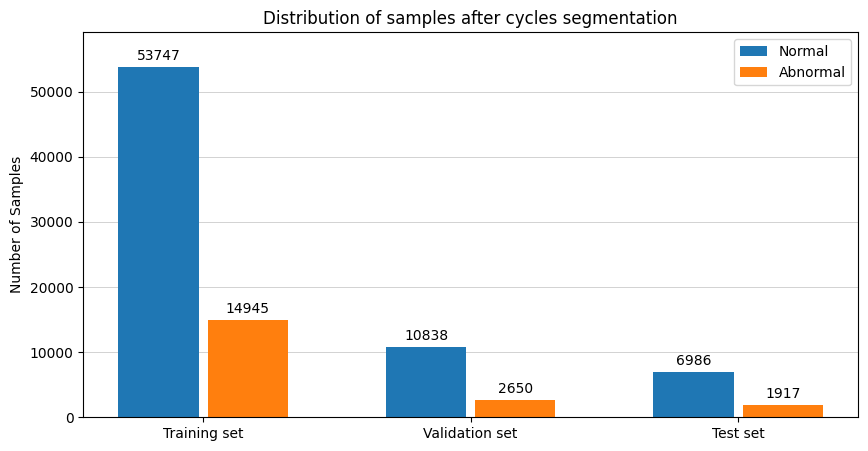

In [64]:
plot_distribution('Dataset/PhysioNetPreprocessedCyclesDeltaMFCC', 'Distribution of samples after cycles segmentation')